#### Code to train models

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [4]:
import os
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm

In [5]:
from params import *

In [6]:
from data.dataset import CovidInfDataset
from data.transforms import get_tranfos_inference

from model_zoo.models import get_model

from utils.logger import Config

## Data

### Load

## Dataset

In [7]:
from data.dataset import CovidInfDataset
from data.transforms import get_tranfos_inference

In [8]:
root = DATA_PATH + f"test_{SIZE}/"
df = pd.read_csv(DATA_PATH + f'df_test_{SIZE}.csv')

In [9]:
transforms = get_tranfos_inference()
dataset = CovidInfDataset(df, root, transforms=transforms)

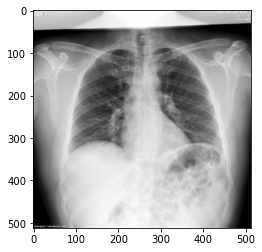

In [10]:
img = dataset[0]
plt.imshow((img.numpy().transpose(1, 2, 0) + 1) / 2)
plt.show()

# Main

In [11]:
from inference.predict import predict
from utils.torch import load_model_weights

def inference(
    config,
    weights,
    df,
    root_dir="",
    log_folder=None,
    flip_tta=False,
    scale_tta=False,
):
    """
    Inference on the test data.
    Args:
        config (Config): Parameters.
        weights (list of strings): Model weights.
        log_folder (None or str, optional): Folder to load the weights from. Defaults to None.
        flip_tta (bool, optional): Whether to use hflip tta. Defaults to False.
        scale_tta (bool, optional): Whether to use scale tta. Defaults to False.
    """

    model = get_model(
        config.selected_model,
        use_unet=config.use_unet,
        num_classes=config.num_classes,
    ).to(config.device)
    model.zero_grad()
    
    dataset = CovidInfDataset(
        df,
        root_dir=root_dir,
        transforms=get_tranfos_inference(mean=model.mean, std=model.std),
    )
    
    preds_study, preds_img = [], []
    for i, weight in enumerate(weights):
        load_model_weights(model, weight)

        pred_study, pred_img = predict(
            model,
            dataset,
            batch_size=config.val_bs,
            num_classes=config.num_classes,
            flip_tta=flip_tta,
            scale_tta=scale_tta,
            device=config.device,
        )
        
        preds_study.append(pred_study)
        preds_img.append(pred_img)
    
    preds_study = np.mean(preds_study, 0)
    preds_img = np.mean(preds_img, 0)
    
    if log_folder is not None:
        suffix = "_flip" * flip_tta + "_scale" * scale_tta
        np.save(log_folder + 'preds_test_study' + suffix + '.npy', preds_study)
        np.save(log_folder + 'preds_test_img' + suffix + '.npy', preds_img)

    return preds_study, preds_img

In [17]:
EXP_FOLDER = LOG_PATH + "2021-07-27/15/"
# EXP_FOLDER = LOG_PATH + "2021-07-28/0/"

config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))
weights = sorted(glob.glob(EXP_FOLDER + "*.pt"))

In [30]:
preds_study, preds_img = inference(
    config,
    weights,
    df,
    root_dir=root,
    log_folder=EXP_FOLDER,
    flip_tta=False,
    scale_tta=False,
)


 -> Loading weights from ../logs/2021-07-27/15/tf_efficientnetv2_m_in21ft1k_model_0.pt


 -> Loading weights from ../logs/2021-07-27/15/tf_efficientnetv2_m_in21ft1k_model_1.pt


 -> Loading weights from ../logs/2021-07-27/15/tf_efficientnetv2_m_in21ft1k_model_2.pt


 -> Loading weights from ../logs/2021-07-27/15/tf_efficientnetv2_m_in21ft1k_model_3.pt


 -> Loading weights from ../logs/2021-07-27/15/tf_efficientnetv2_m_in21ft1k_model_4.pt



In [33]:
len(df), preds_study.shape, preds_img.shape

(1263, (1263, 4), (1263,))

In [18]:
np.load(EXP_FOLDER + "preds_test_study.npy")

array([[0.73876885, 0.08202239, 0.12522555, 0.05398323],
       [0.66237876, 0.18345004, 0.12988935, 0.02428188],
       [0.00650888, 0.93634186, 0.04695254, 0.01019674],
       ...,
       [0.84974705, 0.05930536, 0.0737885 , 0.0171591 ],
       [0.02943746, 0.72561351, 0.11898583, 0.12596317],
       [0.02944304, 0.7602051 , 0.09715251, 0.11319936]])